<h1 style="text-align: center;">Transformer model for stock predicition</h1>

### Parameters

In [129]:
days_for_prediction = 5


### Import of libraries

In [130]:
import pandas as pd;
import os;
import keras;
import numpy as np;
import matplotlib.pyplot as plt;
import tensorflow as tf

### Functions for loading of preprocessed data

In [131]:
def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)


### Functions for preparing data for Transformer model

In [132]:
def split_data_into_training_and_test_sets(df: pd.DataFrame, window_start: int, window_end: int, test_size: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits data into training and test sets.
    """
    data_count = window_end - window_start
    test_data_count = int(data_count * test_size)

    end_of_training_data = window_start + test_data_count

    return df.iloc[window_start : end_of_training_data], df.iloc[end_of_training_data : window_end]

def extract_features_required_for_training(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Extracts features required for training.
    """
    return df[features]

def reshape_data_for_transformer(df: pd.DataFrame, window_size: int, number_of_atributes: int) -> np.ndarray:
    """
    Reshapes data for transformer.
    """
    data = df.to_numpy()
    samples = int(data.shape[0] / window_size)
    array_splits = np.arange(window_size, data.shape[0], window_size)
    splited = np.split(data, array_splits)

    if(splited[-1].shape[0] != window_size):
        splited = splited[:-1]

    result = np.array(splited)
    return result.reshape((samples, window_size, number_of_atributes))

def final_preparation_of_data(initial_data: np.ndarray, window_size: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Final preparation of data.
    """
    data = initial_data.reshape((initial_data.shape[0]*initial_data.shape[1], initial_data.shape[2]))
    x, y = [], []
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + window_size
        out_end = in_end + window_size
        if out_end <= len(data):
            x.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, :])
        in_start += 1

    return np.array(x), np.array(y)


### Positional Encoding

In [133]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

### Functions for building Transformer model

In [134]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout : float =0, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = keras.layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = keras.layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
  x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = keras.layers.Dropout(dropout)(x)
  x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout : float =0, 
                      mlp_dropout : float =0, 
                      attention_axes=None) -> keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = days_for_prediction, 1, days_for_prediction 
  inputs = keras.Input(shape=(n_timesteps, n_features))

  # Add positional encoding layer
  pos_encoding = positional_encoding(n_timesteps, n_features)
  x = inputs + pos_encoding
  
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, attention_axes)
  
  x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(mlp_dropout)(x)

  outputs = keras.layers.Dense(n_outputs, activation='relu')(x)
  return keras.Model(inputs, outputs)

### Functions for predicting of values

In [135]:
def forecast(history : list, model : keras.Model, window_size : int):
    """
    Given last weeks actual data, forecasts next weeks prices.
    """
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-window_size:, :]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose="0")
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat.reshape((window_size, 1))

def get_predictions(model : keras.Model, x_values : np.ndarray, window_size : int):
    history = [x for x in x_values]
    predictions = list()

    for i in range(len(x_values)):
        yhat_sequence = forecast(history, model, window_size)
        predictions.append(yhat_sequence)
        history.append(x_values[i, :])

    return np.array(predictions)

def plot_results(test, preds, df, title_suffix=None, xlabel='AAPL stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(plot_test, label='actual')
  ax.plot(plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  plt.show()

def plot_results_all_predictions_combined(test, preds, df, title_suffix=None, xlabel='AAPL'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = [test[1:] for test in test]
  plot_preds = [pred[1:] for pred in preds]

  #x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index

  plot_test = np.concatenate(plot_test, axis=0)

  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(plot_test, label='actual')

  start_position_x = 0
  for i in range(len(plot_preds)):
    plot_pred = plot_preds[i].reshape((plot_preds[i].shape[0]*plot_preds[i].shape[1], 1))

    plot_x = np.arange(start_position_x, start_position_x + len(plot_pred))

    start_position_x += len(plot_pred)

    ax.plot(plot_x, plot_pred, label='preds-'+ str(i))

  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel + " stock Price")
  ax.legend()
  plt.show()

### Transformer prediction

In [136]:
def transformer_prediction(file: str):
    file_name = file.split("/")[-1]

    file_name_without_extension = file_name.split(".")[0]


    loaded_data = import_data_from_csv(file)
    extracted_data = extract_features_required_for_training(loaded_data, ["Adj Close"])

    number_of_intervals = 5
    percentage_of_test_interval_data = 0.8

    interval_size = int(extracted_data.shape[0] / number_of_intervals)

    training_data, test_data = [], []
    training_values, test_values = [], []
    
    for i in range(number_of_intervals):
        start = i * interval_size
        end = start + interval_size

        if(i == number_of_intervals - 1):
            end = extracted_data.shape[0]

        training_data_interval, test_data_interval = split_data_into_training_and_test_sets(extracted_data, start, end, percentage_of_test_interval_data)
        reshaped_training_data_interval = reshape_data_for_transformer(training_data_interval, days_for_prediction, 1)
        reshaped_test_data_interval = reshape_data_for_transformer(test_data_interval, days_for_prediction, 1)

        training_data.append(reshaped_training_data_interval)
        test_data.append(reshaped_test_data_interval)

        training_x_values_interval, training_y_values_interval = final_preparation_of_data(reshaped_training_data_interval, days_for_prediction)
        test_x_values_interval, test_y_values_interval = final_preparation_of_data(reshaped_test_data_interval, days_for_prediction)

        if(i != 0):
            training_x_values_interval = np.concatenate((test_values[i - 1][0], training_x_values_interval))
            training_y_values_interval = np.concatenate((test_values[i - 1][1], training_y_values_interval))

        training_values.append((training_x_values_interval, training_y_values_interval))
        test_values.append((test_x_values_interval, test_y_values_interval))

    transformer = build_transfromer(head_size=128, num_heads=4, ff_dim= 2, 
                                    num_trans_blocks=8, mlp_units=[256, 256], 
                                    mlp_dropout=0.1, dropout=0.1, attention_axes=0)

    transformer.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["mae", 'mape'],
    )

    prediction_inputs_list = []
    predictions_list = []

    for i in range(number_of_intervals):
        training_x_values, training_y_values = training_values[i] 
        validation_x_values, validation_y_values = test_values[i] 

        file_path = "checkpoints/" + file_name_without_extension + "/transformer-" + str(i + 1) + ".keras"

        if(os.path.exists(file_path)):
            transformer = keras.models.load_model(file_path)
        else:
            file_path_previos = "checkpoints/transformer-" + str(i) + ".keras"

            if(os.path.exists(file_path_previos)):
                transformer = keras.models.load_model(file_path_previos)

            callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=10, 
                                                restore_best_weights=True)]
            
            epochs = 15
            if(i == 0):
                epochs = 50

            t_hist = transformer.fit(training_x_values, training_y_values, batch_size=15,
                                epochs=epochs, callbacks=callbacks, validation_data=(validation_x_values, validation_y_values), verbose=1)

            pd.DataFrame(t_hist.history).plot(figsize=(8,5))
            plt.show()
            
            transformer.save(file_path)

        prediction_inputs = np.concatenate((training_data[i], test_data[i]))

        prediction_inputs_list.append(prediction_inputs)

        predictions = get_predictions(transformer, prediction_inputs, days_for_prediction)

        predictions_list.append(predictions)

    plot_results_all_predictions_combined(prediction_inputs_list, predictions_list, extracted_data, title_suffix=file_name_without_extension, xlabel=file_name_without_extension)   


### Main Implementation

Epoch 1/50
35/35 [==============================] - 24s 86ms/step - loss: 171.9839 - mae: 12.3116 - mape: 85.5510 - val_loss: 115.6080 - val_mae: 9.7166 - val_mape: 72.3661
Epoch 2/50
35/35 [==============================] - 2s 44ms/step - loss: 123.1568 - mae: 9.0026 - mape: 62.5565 - val_loss: 77.1343 - val_mae: 6.6793 - val_mape: 49.7633
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 90.1075 - mae: 6.7073 - mape: 46.8448 - val_loss: 72.4725 - val_mae: 5.6822 - val_mape: 42.3477
Epoch 4/50
35/35 [==============================] - 1s 41ms/step - loss: 88.9380 - mae: 6.4838 - mape: 45.1654 - val_loss: 72.2509 - val_mae: 5.5550 - val_mape: 41.3912
Epoch 5/50
35/35 [==============================] - 2s 44ms/step - loss: 88.8512 - mae: 6.4762 - mape: 45.1358 - val_loss: 72.2684 - val_mae: 5.5741 - val_mape: 41.5384
Epoch 6/50
35/35 [==============================] - 1s 41ms/step - loss: 88.7110 - mae: 6.4333 - mape: 44.8145 - val_loss: 72.2465 - val_mae: 5.5506 -

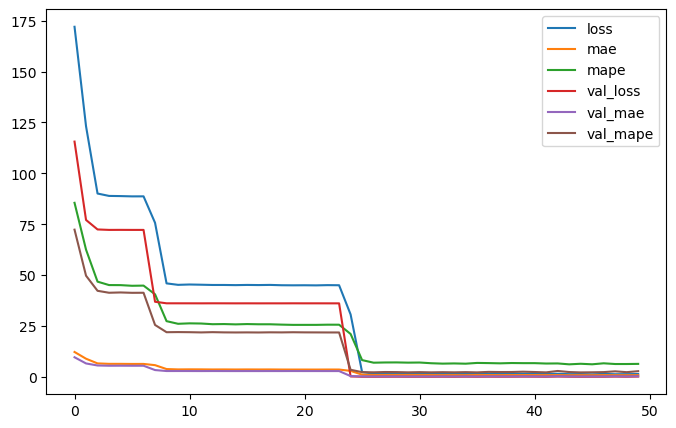

Epoch 1/15
43/43 [==============================] - 2s 44ms/step - loss: 2.6337 - mae: 1.2553 - mape: 6.2187 - val_loss: 0.4088 - val_mae: 0.5203 - val_mape: 2.1115
Epoch 2/15
43/43 [==============================] - 2s 44ms/step - loss: 2.5904 - mae: 1.2361 - mape: 6.0374 - val_loss: 0.3166 - val_mae: 0.4619 - val_mape: 1.8758
Epoch 3/15
43/43 [==============================] - 2s 42ms/step - loss: 2.4324 - mae: 1.1965 - mape: 5.9070 - val_loss: 0.3504 - val_mae: 0.4691 - val_mape: 1.9170
Epoch 4/15
43/43 [==============================] - 2s 40ms/step - loss: 2.6137 - mae: 1.2333 - mape: 6.0107 - val_loss: 0.3199 - val_mae: 0.4633 - val_mape: 1.8815
Epoch 5/15
43/43 [==============================] - 2s 41ms/step - loss: 2.5476 - mae: 1.2254 - mape: 5.9987 - val_loss: 0.3569 - val_mae: 0.4752 - val_mape: 1.9306
Epoch 6/15
43/43 [==============================] - 2s 43ms/step - loss: 2.5859 - mae: 1.2423 - mape: 6.1065 - val_loss: 0.3248 - val_mae: 0.4540 - val_mape: 1.8464
Epoch 7/15

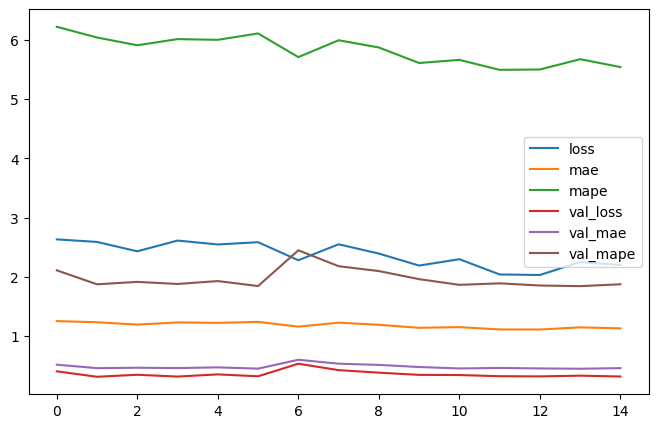

Epoch 1/15
43/43 [==============================] - 2s 42ms/step - loss: 4.9093 - mae: 1.7241 - mape: 5.6433 - val_loss: 1.8543 - val_mae: 1.0814 - val_mape: 2.2840
Epoch 2/15
43/43 [==============================] - 2s 46ms/step - loss: 4.5588 - mae: 1.6633 - mape: 5.4725 - val_loss: 3.1201 - val_mae: 1.5372 - val_mape: 3.2294
Epoch 3/15
43/43 [==============================] - 2s 39ms/step - loss: 4.6662 - mae: 1.6889 - mape: 5.5344 - val_loss: 4.0222 - val_mae: 1.7739 - val_mape: 3.7265
Epoch 4/15
43/43 [==============================] - 2s 41ms/step - loss: 4.2898 - mae: 1.6141 - mape: 5.2903 - val_loss: 1.6549 - val_mae: 1.0490 - val_mape: 2.2206
Epoch 5/15
43/43 [==============================] - 2s 45ms/step - loss: 4.1894 - mae: 1.6096 - mape: 5.3296 - val_loss: 1.1587 - val_mae: 0.8439 - val_mape: 1.7933
Epoch 6/15
43/43 [==============================] - 2s 47ms/step - loss: 3.8838 - mae: 1.5482 - mape: 5.1127 - val_loss: 1.7979 - val_mae: 1.0610 - val_mape: 2.2430
Epoch 7/15

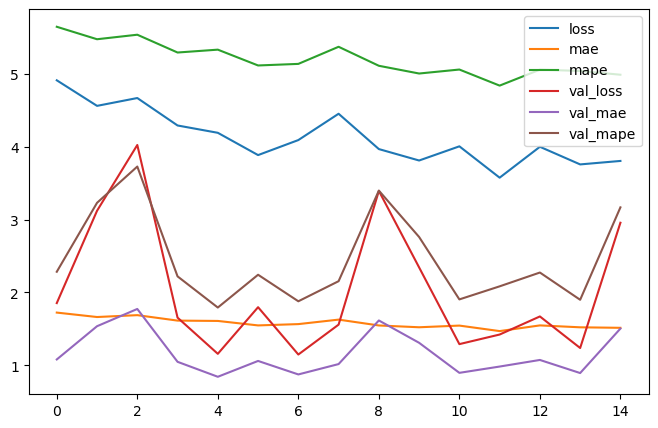

Epoch 1/15
43/43 [==============================] - 2s 49ms/step - loss: 22.7000 - mae: 3.6074 - mape: 5.8737 - val_loss: 9.6725 - val_mae: 2.5099 - val_mape: 1.9896
Epoch 2/15
43/43 [==============================] - 2s 44ms/step - loss: 21.4016 - mae: 3.3879 - mape: 5.4017 - val_loss: 9.1786 - val_mae: 2.4639 - val_mape: 1.9511
Epoch 3/15
43/43 [==============================] - 2s 45ms/step - loss: 19.3524 - mae: 3.2553 - mape: 5.1781 - val_loss: 11.6780 - val_mae: 2.7630 - val_mape: 2.1948
Epoch 4/15
43/43 [==============================] - 3s 73ms/step - loss: 19.7727 - mae: 3.2248 - mape: 5.1624 - val_loss: 12.2765 - val_mae: 2.7663 - val_mape: 2.1980
Epoch 5/15
43/43 [==============================] - 3s 61ms/step - loss: 18.7179 - mae: 3.2097 - mape: 5.1163 - val_loss: 20.6926 - val_mae: 3.8447 - val_mape: 3.0430
Epoch 6/15
43/43 [==============================] - 2s 52ms/step - loss: 18.5917 - mae: 3.1845 - mape: 5.1445 - val_loss: 8.8265 - val_mae: 2.4373 - val_mape: 1.9314
E

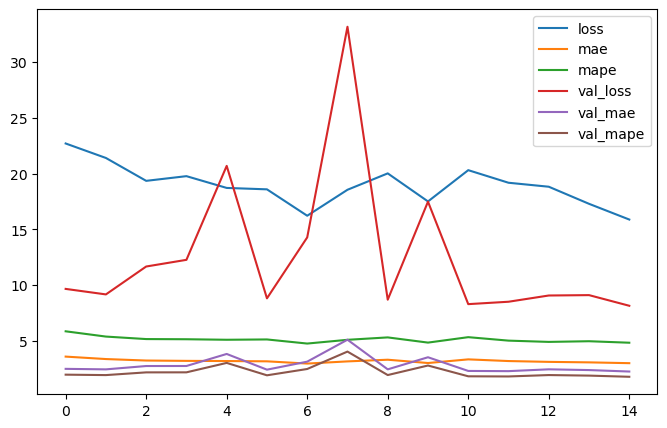

Epoch 1/15
43/43 [==============================] - 2s 42ms/step - loss: 81.9492 - mae: 7.2244 - mape: 4.8965 - val_loss: 18.5702 - val_mae: 3.6206 - val_mape: 1.9803
Epoch 2/15
43/43 [==============================] - 2s 42ms/step - loss: 78.6821 - mae: 6.9742 - mape: 4.7288 - val_loss: 34.1663 - val_mae: 5.2286 - val_mape: 2.8360
Epoch 3/15
43/43 [==============================] - 2s 41ms/step - loss: 77.0034 - mae: 6.9183 - mape: 4.6740 - val_loss: 51.0765 - val_mae: 6.4003 - val_mape: 3.4763
Epoch 4/15
43/43 [==============================] - 2s 42ms/step - loss: 75.3659 - mae: 6.9763 - mape: 4.7164 - val_loss: 19.8789 - val_mae: 3.8658 - val_mape: 2.1009
Epoch 5/15
43/43 [==============================] - 2s 42ms/step - loss: 70.0509 - mae: 6.6767 - mape: 4.5504 - val_loss: 17.3814 - val_mae: 3.5850 - val_mape: 1.9492
Epoch 6/15
43/43 [==============================] - 2s 42ms/step - loss: 69.4438 - mae: 6.6281 - mape: 4.4961 - val_loss: 12.8470 - val_mae: 2.9660 - val_mape: 1.619

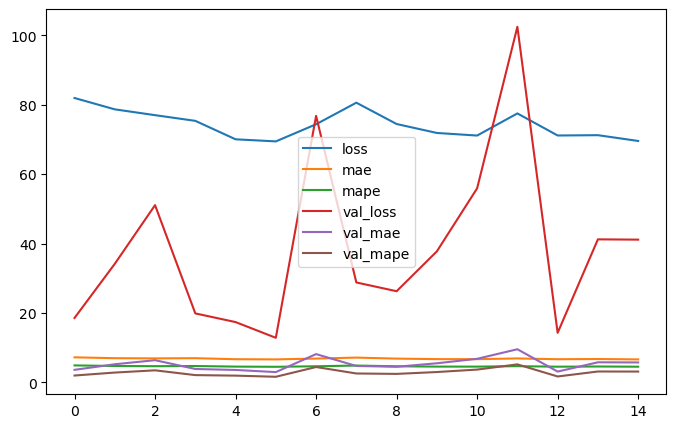

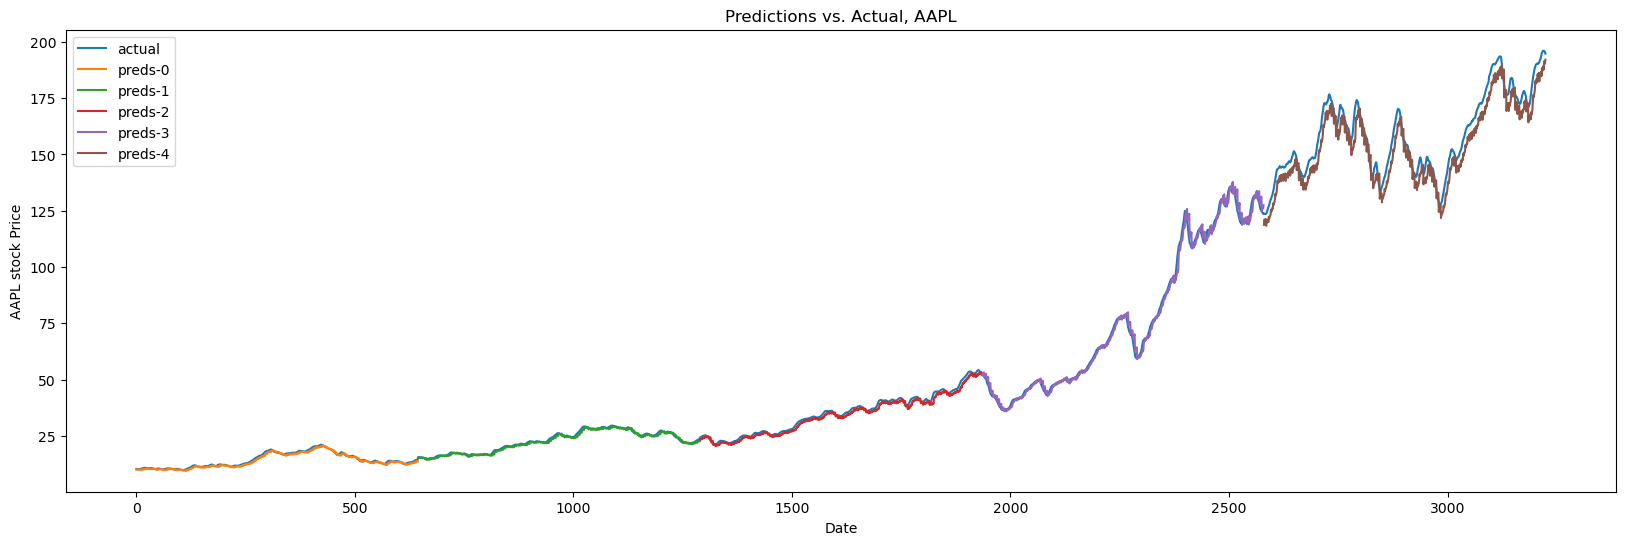

Epoch 1/50
35/35 [==============================] - 29s 114ms/step - loss: 130.0107 - mae: 10.6176 - mape: 69.7753 - val_loss: 140.6717 - val_mae: 10.2767 - val_mape: 48.4509
Epoch 2/50
35/35 [==============================] - 2s 44ms/step - loss: 42.9608 - mae: 4.6187 - mape: 30.2742 - val_loss: 15.6821 - val_mae: 2.4783 - val_mape: 11.6756
Epoch 3/50
35/35 [==============================] - 2s 45ms/step - loss: 5.1002 - mae: 1.7680 - mape: 11.6682 - val_loss: 0.5888 - val_mae: 0.6560 - val_mape: 3.0726
Epoch 4/50
35/35 [==============================] - 2s 48ms/step - loss: 3.3313 - mae: 1.4423 - mape: 9.5179 - val_loss: 1.3011 - val_mae: 1.0612 - val_mape: 4.9788
Epoch 5/50
35/35 [==============================] - 2s 44ms/step - loss: 3.3041 - mae: 1.4322 - mape: 9.4404 - val_loss: 0.6949 - val_mae: 0.7424 - val_mape: 3.4743
Epoch 6/50
35/35 [==============================] - 2s 43ms/step - loss: 3.2301 - mae: 1.4267 - mape: 9.3761 - val_loss: 0.8441 - val_mae: 0.8255 - val_mape: 3.

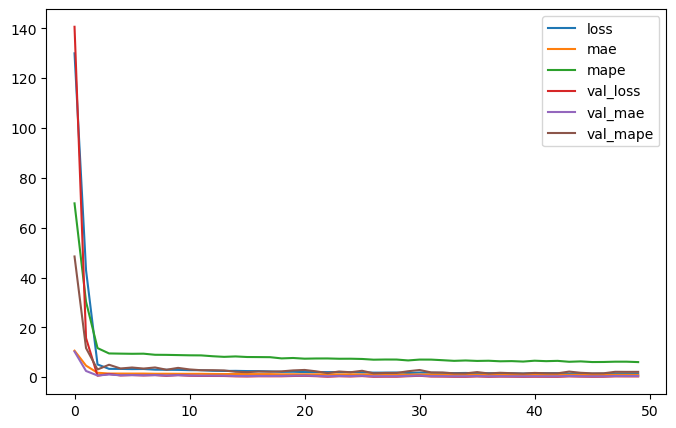

Epoch 1/15
43/43 [==============================] - 2s 51ms/step - loss: 3.9072 - mae: 1.5624 - mape: 5.9842 - val_loss: 0.7494 - val_mae: 0.6751 - val_mape: 1.9184
Epoch 2/15
43/43 [==============================] - 2s 51ms/step - loss: 3.7548 - mae: 1.5134 - mape: 5.7781 - val_loss: 0.5420 - val_mae: 0.5497 - val_mape: 1.5693
Epoch 3/15
43/43 [==============================] - 2s 47ms/step - loss: 3.5732 - mae: 1.4963 - mape: 5.7257 - val_loss: 0.6299 - val_mae: 0.6249 - val_mape: 1.7841
Epoch 4/15
43/43 [==============================] - 2s 43ms/step - loss: 3.9841 - mae: 1.5684 - mape: 5.9782 - val_loss: 0.7360 - val_mae: 0.7008 - val_mape: 1.9995
Epoch 5/15
43/43 [==============================] - 2s 51ms/step - loss: 3.6554 - mae: 1.5178 - mape: 5.7982 - val_loss: 0.5571 - val_mae: 0.5580 - val_mape: 1.5926
Epoch 6/15
43/43 [==============================] - 2s 49ms/step - loss: 3.5272 - mae: 1.4805 - mape: 5.6750 - val_loss: 2.2439 - val_mae: 1.3652 - val_mape: 3.8763
Epoch 7/15

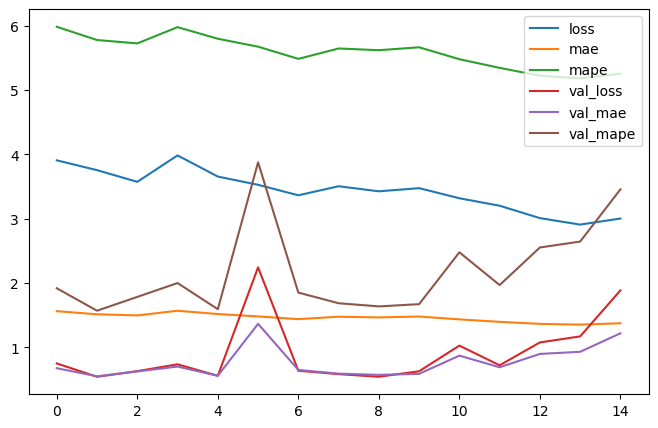

Epoch 1/15
43/43 [==============================] - 3s 68ms/step - loss: 8.0676 - mae: 2.2123 - mape: 5.2164 - val_loss: 1.7284 - val_mae: 1.0139 - val_mape: 1.7632
Epoch 2/15
43/43 [==============================] - 3s 67ms/step - loss: 7.9564 - mae: 2.2212 - mape: 5.2311 - val_loss: 2.1567 - val_mae: 1.2103 - val_mape: 2.1044
Epoch 3/15
43/43 [==============================] - 3s 63ms/step - loss: 8.2768 - mae: 2.2354 - mape: 5.2539 - val_loss: 6.4924 - val_mae: 2.3443 - val_mape: 4.0688
Epoch 4/15
43/43 [==============================] - 4s 103ms/step - loss: 7.8634 - mae: 2.1685 - mape: 5.1041 - val_loss: 7.1363 - val_mae: 2.4839 - val_mape: 4.3105
Epoch 5/15
43/43 [==============================] - 3s 64ms/step - loss: 7.0253 - mae: 2.0810 - mape: 4.9309 - val_loss: 1.2272 - val_mae: 0.8863 - val_mape: 1.5432
Epoch 6/15
43/43 [==============================] - 3s 60ms/step - loss: 7.7419 - mae: 2.1698 - mape: 5.1491 - val_loss: 2.5228 - val_mae: 1.3547 - val_mape: 2.3536
Epoch 7/1

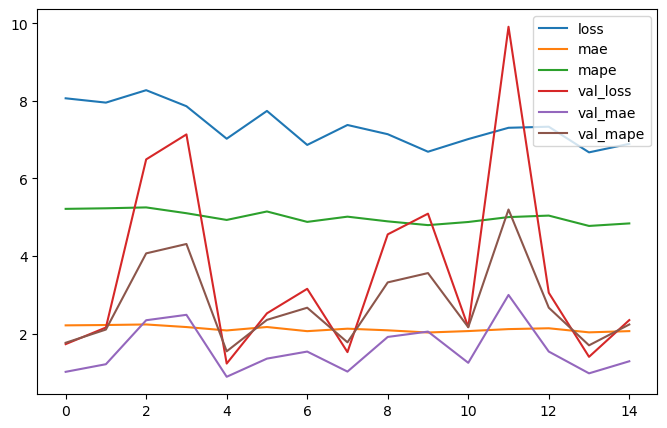

Epoch 1/15
43/43 [==============================] - 2s 55ms/step - loss: 14.5335 - mae: 2.9960 - mape: 4.7668 - val_loss: 10.3937 - val_mae: 2.5991 - val_mape: 2.5490
Epoch 2/15
43/43 [==============================] - 2s 54ms/step - loss: 14.5980 - mae: 3.0048 - mape: 4.8012 - val_loss: 10.7924 - val_mae: 2.6211 - val_mape: 2.5699
Epoch 3/15
43/43 [==============================] - 2s 54ms/step - loss: 13.9862 - mae: 2.9244 - mape: 4.6497 - val_loss: 12.4605 - val_mae: 2.8986 - val_mape: 2.8469
Epoch 4/15
43/43 [==============================] - 2s 50ms/step - loss: 14.5228 - mae: 3.0026 - mape: 4.7876 - val_loss: 18.8302 - val_mae: 3.8408 - val_mape: 3.7841
Epoch 5/15
43/43 [==============================] - 2s 54ms/step - loss: 15.3513 - mae: 3.0616 - mape: 4.8659 - val_loss: 15.7549 - val_mae: 3.3563 - val_mape: 3.3019
Epoch 6/15
43/43 [==============================] - 2s 55ms/step - loss: 14.7737 - mae: 3.0073 - mape: 4.7992 - val_loss: 6.2858 - val_mae: 1.9052 - val_mape: 1.8615

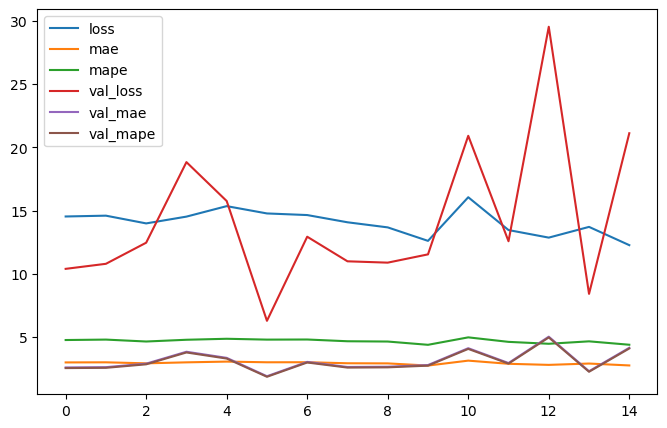

Epoch 1/15
43/43 [==============================] - 3s 65ms/step - loss: 49.9124 - mae: 5.5042 - mape: 4.7283 - val_loss: 25.5135 - val_mae: 4.5974 - val_mape: 3.4726
Epoch 2/15
43/43 [==============================] - 3s 63ms/step - loss: 46.3523 - mae: 5.4275 - mape: 4.6936 - val_loss: 62.8140 - val_mae: 7.5465 - val_mape: 5.7005
Epoch 3/15
43/43 [==============================] - 2s 57ms/step - loss: 47.7570 - mae: 5.4138 - mape: 4.6557 - val_loss: 7.7954 - val_mae: 2.0764 - val_mape: 1.5732
Epoch 4/15
43/43 [==============================] - 3s 60ms/step - loss: 46.6023 - mae: 5.3630 - mape: 4.6060 - val_loss: 12.5691 - val_mae: 3.1297 - val_mape: 2.3630
Epoch 5/15
43/43 [==============================] - 3s 58ms/step - loss: 44.7303 - mae: 5.2985 - mape: 4.5920 - val_loss: 23.1892 - val_mae: 4.4123 - val_mape: 3.3332
Epoch 6/15
43/43 [==============================] - 2s 51ms/step - loss: 44.8830 - mae: 5.2623 - mape: 4.5492 - val_loss: 22.5230 - val_mae: 4.2993 - val_mape: 3.2476

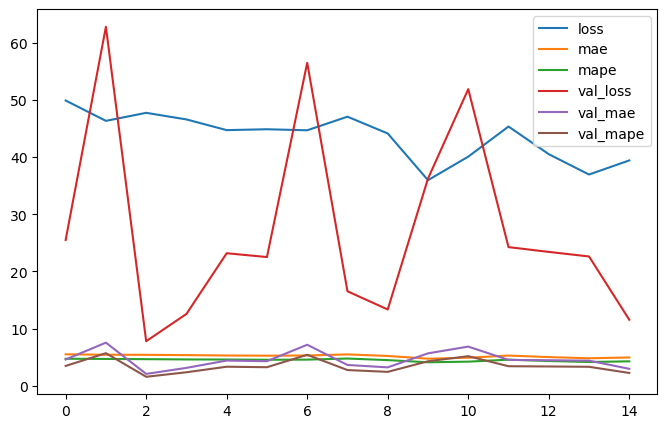

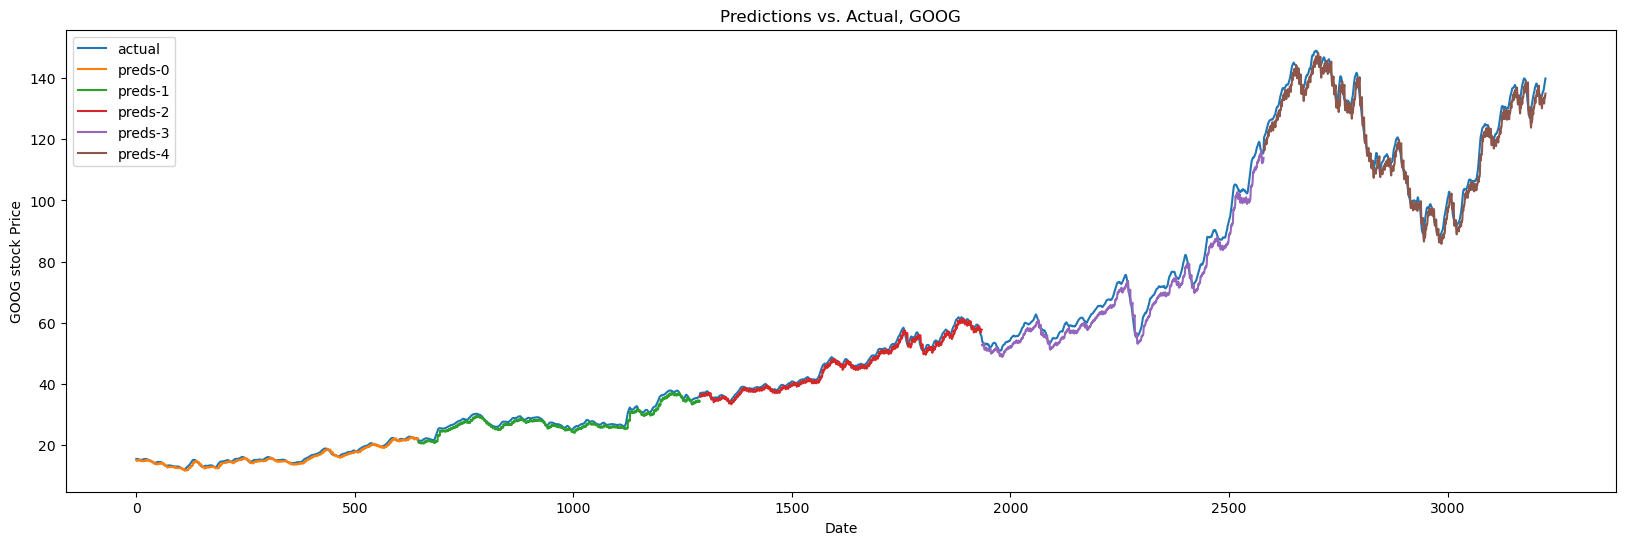

Epoch 1/50
35/35 [==============================] - 38s 148ms/step - loss: 350.5560 - mae: 18.0868 - mape: 81.3842 - val_loss: 300.5567 - val_mae: 16.1325 - val_mape: 61.4867
Epoch 2/50
35/35 [==============================] - 2s 66ms/step - loss: 145.6414 - mae: 9.6257 - mape: 43.2973 - val_loss: 144.2447 - val_mae: 7.0474 - val_mape: 26.7980
Epoch 3/50
35/35 [==============================] - 3s 78ms/step - loss: 77.1076 - mae: 5.2463 - mape: 23.5805 - val_loss: 19.4440 - val_mae: 2.4051 - val_mape: 9.1119
Epoch 4/50
35/35 [==============================] - 3s 74ms/step - loss: 7.8099 - mae: 2.1540 - mape: 9.7080 - val_loss: 0.8112 - val_mae: 0.7273 - val_mape: 2.7193
Epoch 5/50
35/35 [==============================] - 3s 75ms/step - loss: 6.1145 - mae: 1.9639 - mape: 8.8598 - val_loss: 0.7343 - val_mae: 0.6801 - val_mape: 2.5115
Epoch 6/50
35/35 [==============================] - 2s 71ms/step - loss: 6.0360 - mae: 1.9593 - mape: 8.8266 - val_loss: 0.5434 - val_mae: 0.5555 - val_mape

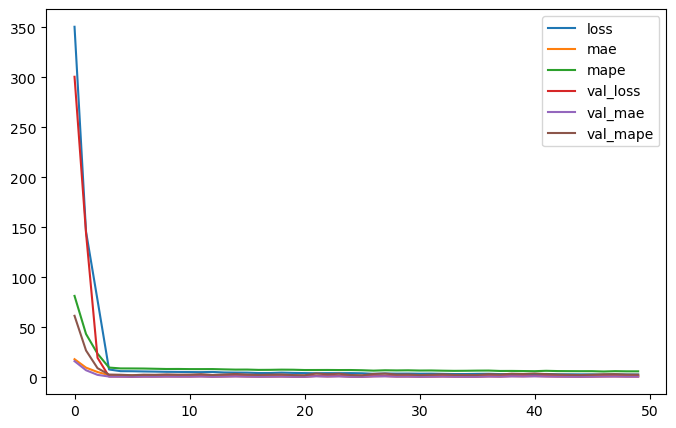

Epoch 1/15
43/43 [==============================] - 4s 100ms/step - loss: 6.7617 - mae: 2.0296 - mape: 5.9157 - val_loss: 1.6767 - val_mae: 1.0153 - val_mape: 2.2346
Epoch 2/15
43/43 [==============================] - 4s 85ms/step - loss: 6.6191 - mae: 2.0240 - mape: 5.9028 - val_loss: 2.9745 - val_mae: 1.5014 - val_mape: 3.3006
Epoch 3/15
43/43 [==============================] - 3s 69ms/step - loss: 6.3132 - mae: 1.9804 - mape: 5.8094 - val_loss: 1.1392 - val_mae: 0.7708 - val_mape: 1.6922
Epoch 4/15
43/43 [==============================] - 3s 65ms/step - loss: 6.0671 - mae: 1.9187 - mape: 5.5881 - val_loss: 1.3115 - val_mae: 0.8550 - val_mape: 1.8618
Epoch 5/15
43/43 [==============================] - 3s 65ms/step - loss: 6.6119 - mae: 2.0424 - mape: 5.9804 - val_loss: 1.2289 - val_mae: 0.8138 - val_mape: 1.7765
Epoch 6/15
43/43 [==============================] - 3s 68ms/step - loss: 5.8824 - mae: 1.9013 - mape: 5.5631 - val_loss: 1.0991 - val_mae: 0.7473 - val_mape: 1.6429
Epoch 7/1

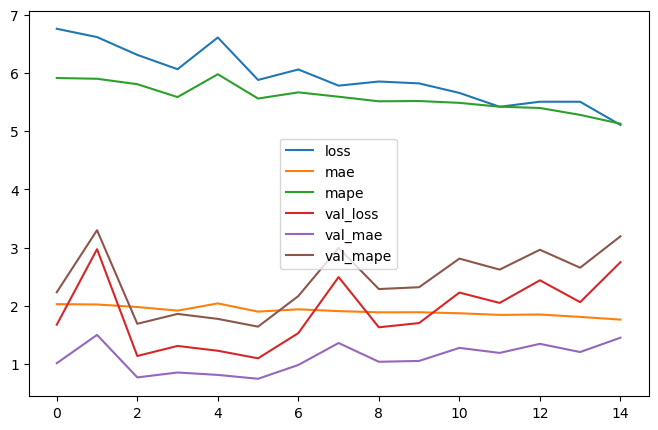

Epoch 1/15
43/43 [==============================] - 3s 59ms/step - loss: 16.1001 - mae: 3.1289 - mape: 5.2498 - val_loss: 17.0911 - val_mae: 3.9367 - val_mape: 4.0015
Epoch 2/15
43/43 [==============================] - 2s 57ms/step - loss: 14.8524 - mae: 3.0129 - mape: 5.0735 - val_loss: 8.3208 - val_mae: 2.5784 - val_mape: 2.6179
Epoch 3/15
43/43 [==============================] - 2s 54ms/step - loss: 15.9873 - mae: 3.1250 - mape: 5.2631 - val_loss: 9.9058 - val_mae: 2.8963 - val_mape: 2.9435
Epoch 4/15
43/43 [==============================] - 2s 54ms/step - loss: 14.9541 - mae: 3.0067 - mape: 5.0204 - val_loss: 2.5547 - val_mae: 1.2390 - val_mape: 1.2551
Epoch 5/15
43/43 [==============================] - 3s 56ms/step - loss: 13.7655 - mae: 2.8805 - mape: 4.8574 - val_loss: 6.1818 - val_mae: 2.2490 - val_mape: 2.2844
Epoch 6/15
43/43 [==============================] - 2s 55ms/step - loss: 15.3416 - mae: 3.1051 - mape: 5.2522 - val_loss: 6.8339 - val_mae: 2.3649 - val_mape: 2.4014
Epo

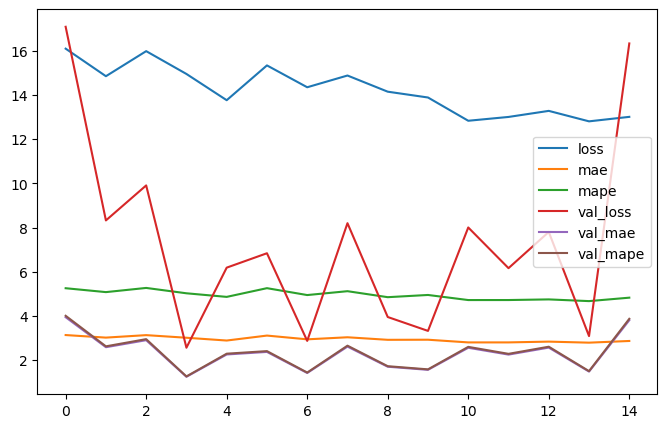

Epoch 1/15
43/43 [==============================] - 3s 73ms/step - loss: 93.9836 - mae: 7.4111 - mape: 5.3240 - val_loss: 68.8801 - val_mae: 7.1760 - val_mape: 3.1348
Epoch 2/15
43/43 [==============================] - 3s 60ms/step - loss: 79.8953 - mae: 6.8200 - mape: 4.9177 - val_loss: 134.6824 - val_mae: 10.6040 - val_mape: 4.6439
Epoch 3/15
43/43 [==============================] - 3s 62ms/step - loss: 82.2489 - mae: 6.8874 - mape: 4.9627 - val_loss: 22.5394 - val_mae: 3.7380 - val_mape: 1.6237
Epoch 4/15
43/43 [==============================] - 3s 68ms/step - loss: 75.2061 - mae: 6.5905 - mape: 4.7674 - val_loss: 68.8499 - val_mae: 7.1317 - val_mape: 3.1173
Epoch 5/15
43/43 [==============================] - 3s 71ms/step - loss: 71.0208 - mae: 6.4993 - mape: 4.7056 - val_loss: 76.0076 - val_mae: 7.6188 - val_mape: 3.3323
Epoch 6/15
43/43 [==============================] - 3s 65ms/step - loss: 73.3820 - mae: 6.5570 - mape: 4.7290 - val_loss: 21.8738 - val_mae: 3.7141 - val_mape: 1.6

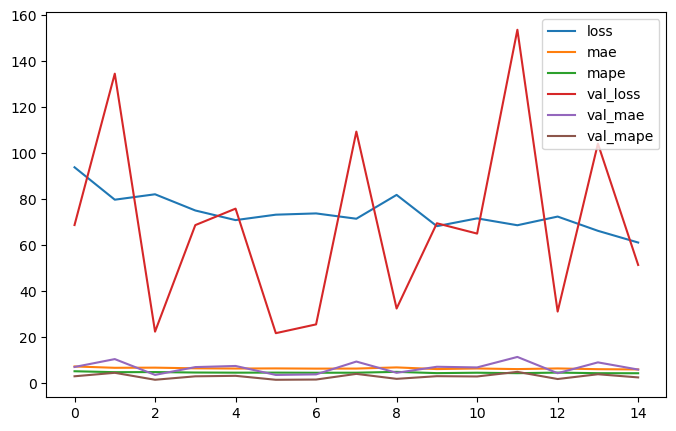

Epoch 1/15
43/43 [==============================] - 3s 69ms/step - loss: 249.4528 - mae: 12.4959 - mape: 4.6873 - val_loss: 40.0751 - val_mae: 4.9615 - val_mape: 1.4603
Epoch 2/15
43/43 [==============================] - 3s 64ms/step - loss: 264.9928 - mae: 12.9996 - mape: 4.8734 - val_loss: 47.4721 - val_mae: 5.4742 - val_mape: 1.6071
Epoch 3/15
43/43 [==============================] - 3s 66ms/step - loss: 248.2324 - mae: 12.4810 - mape: 4.6825 - val_loss: 93.1771 - val_mae: 8.2653 - val_mape: 2.4083
Epoch 4/15
43/43 [==============================] - 3s 71ms/step - loss: 236.5153 - mae: 12.0132 - mape: 4.5145 - val_loss: 218.2914 - val_mae: 13.4791 - val_mape: 3.9322
Epoch 5/15
43/43 [==============================] - 3s 65ms/step - loss: 242.9899 - mae: 12.3943 - mape: 4.6565 - val_loss: 77.5588 - val_mae: 7.5008 - val_mape: 2.1872
Epoch 6/15
43/43 [==============================] - 3s 72ms/step - loss: 218.6234 - mae: 11.8661 - mape: 4.4598 - val_loss: 182.7697 - val_mae: 12.1397 -

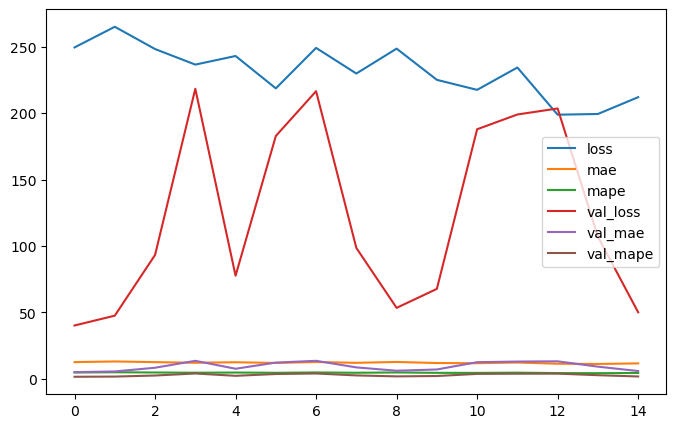

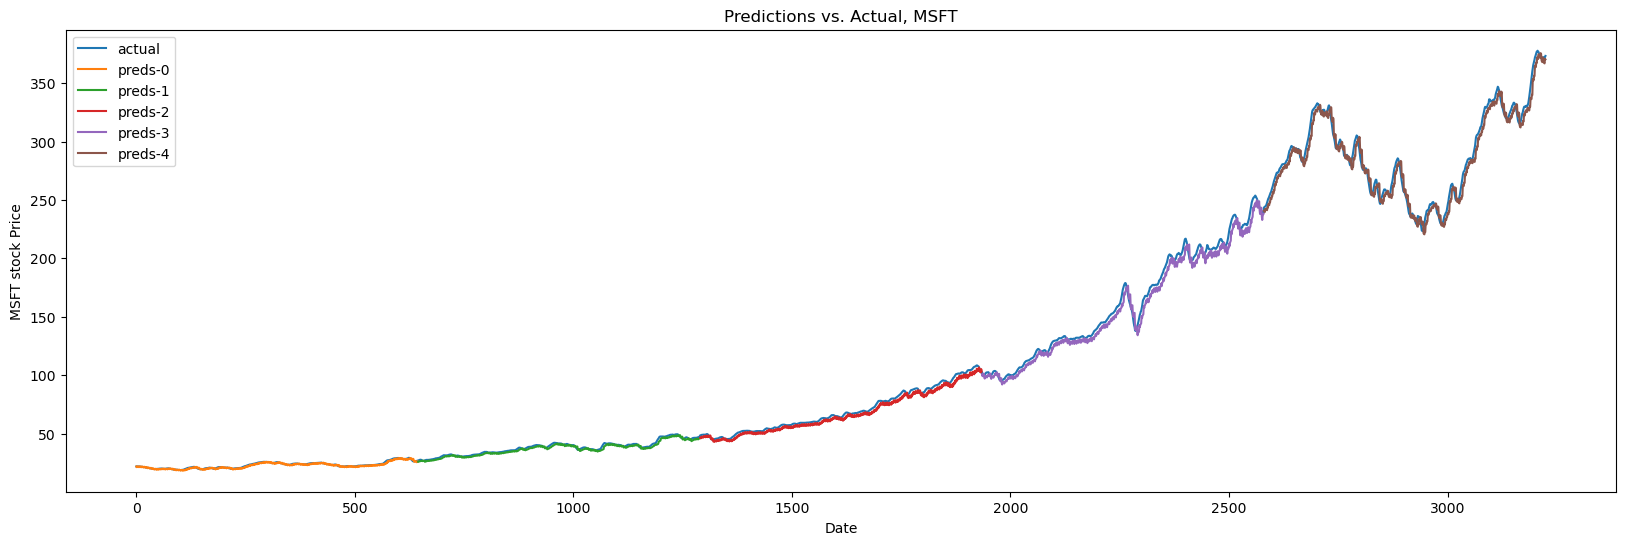

Epoch 1/50
35/35 [==============================] - 44s 135ms/step - loss: 341.9276 - mae: 15.7408 - mape: 80.5825 - val_loss: 412.7313 - val_mae: 19.0364 - val_mape: 63.0348
Epoch 2/50
35/35 [==============================] - 4s 103ms/step - loss: 149.6601 - mae: 8.6352 - mape: 43.1700 - val_loss: 196.0790 - val_mae: 8.5775 - val_mape: 28.1886
Epoch 3/50
35/35 [==============================] - 3s 77ms/step - loss: 101.0979 - mae: 5.6398 - mape: 30.2733 - val_loss: 124.5171 - val_mae: 5.7012 - val_mape: 18.8016
Epoch 4/50
35/35 [==============================] - 3s 84ms/step - loss: 28.1215 - mae: 3.3022 - mape: 17.9259 - val_loss: 2.6243 - val_mae: 1.1754 - val_mape: 3.8141
Epoch 5/50
35/35 [==============================] - 3s 81ms/step - loss: 8.6426 - mae: 2.1936 - mape: 12.5730 - val_loss: 2.5487 - val_mae: 1.1026 - val_mape: 3.5318
Epoch 6/50
35/35 [==============================] - 3s 76ms/step - loss: 8.2831 - mae: 2.0874 - mape: 11.5148 - val_loss: 2.4777 - val_mae: 1.1024 - 

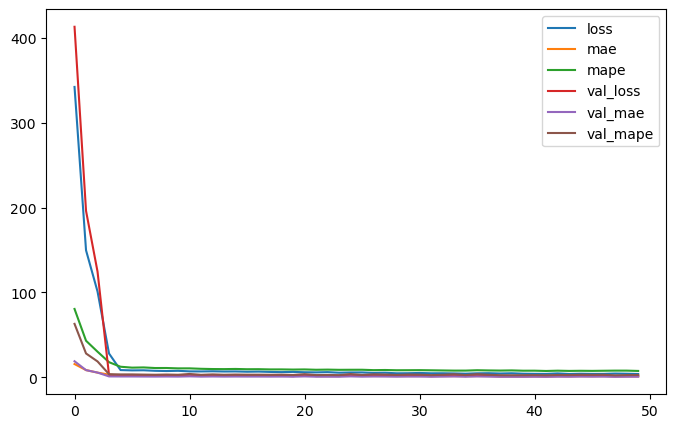

Epoch 1/15
43/43 [==============================] - 4s 98ms/step - loss: 24.3088 - mae: 3.7050 - mape: 6.5038 - val_loss: 25.3761 - val_mae: 4.3094 - val_mape: 4.0468
Epoch 2/15
43/43 [==============================] - 9s 212ms/step - loss: 23.4854 - mae: 3.6336 - mape: 6.3588 - val_loss: 20.3349 - val_mae: 3.8917 - val_mape: 3.6578
Epoch 3/15
43/43 [==============================] - 5s 123ms/step - loss: 24.8045 - mae: 3.7052 - mape: 6.4998 - val_loss: 11.9911 - val_mae: 2.8360 - val_mape: 2.6854
Epoch 4/15
43/43 [==============================] - 4s 98ms/step - loss: 24.3679 - mae: 3.5747 - mape: 6.1470 - val_loss: 18.9792 - val_mae: 3.6341 - val_mape: 3.4282
Epoch 5/15
43/43 [==============================] - 3s 76ms/step - loss: 24.0428 - mae: 3.5564 - mape: 6.1271 - val_loss: 11.1413 - val_mae: 2.6892 - val_mape: 2.5471
Epoch 6/15
43/43 [==============================] - 3s 68ms/step - loss: 21.9502 - mae: 3.4792 - mape: 6.0029 - val_loss: 24.6427 - val_mae: 4.2631 - val_mape: 3.9

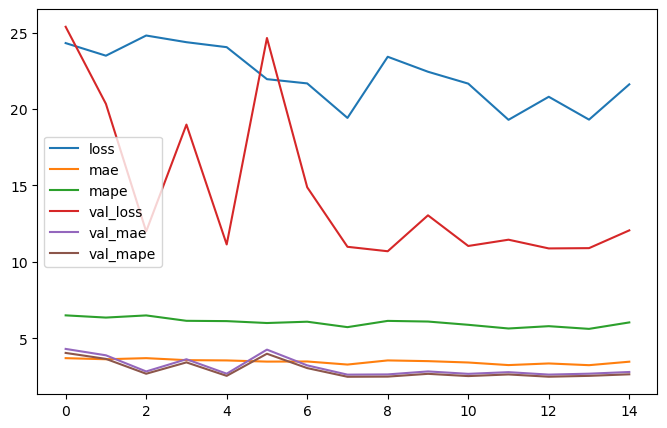

Epoch 1/15
43/43 [==============================] - 3s 59ms/step - loss: 137.7409 - mae: 8.8526 - mape: 6.0666 - val_loss: 116.4938 - val_mae: 9.0853 - val_mape: 2.5267
Epoch 2/15
43/43 [==============================] - 3s 70ms/step - loss: 141.1368 - mae: 8.6611 - mape: 5.8596 - val_loss: 93.7055 - val_mae: 7.4234 - val_mape: 2.0672
Epoch 3/15
43/43 [==============================] - 3s 68ms/step - loss: 115.7423 - mae: 7.8886 - mape: 5.3331 - val_loss: 100.5348 - val_mae: 7.7218 - val_mape: 2.1432
Epoch 4/15
43/43 [==============================] - 3s 60ms/step - loss: 124.4013 - mae: 7.9887 - mape: 5.4178 - val_loss: 211.7959 - val_mae: 11.5927 - val_mape: 3.2444
Epoch 5/15
43/43 [==============================] - 2s 57ms/step - loss: 111.8317 - mae: 7.7694 - mape: 5.2913 - val_loss: 189.7128 - val_mae: 12.0760 - val_mape: 3.3625
Epoch 6/15
43/43 [==============================] - 3s 63ms/step - loss: 101.2161 - mae: 7.4780 - mape: 5.1209 - val_loss: 93.8614 - val_mae: 7.7657 - val

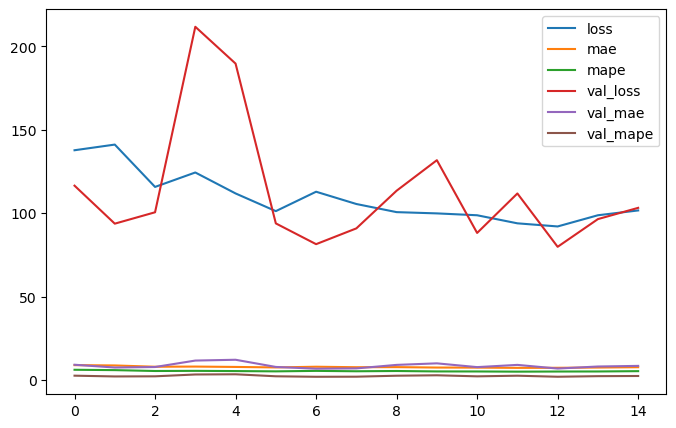

Epoch 1/15
43/43 [==============================] - 3s 71ms/step - loss: 563.1014 - mae: 18.6426 - mape: 5.0961 - val_loss: 104.2564 - val_mae: 7.8168 - val_mape: 1.4909
Epoch 2/15
43/43 [==============================] - 3s 65ms/step - loss: 572.3792 - mae: 18.7993 - mape: 5.1675 - val_loss: 643.1505 - val_mae: 23.4956 - val_mape: 4.4910
Epoch 3/15
43/43 [==============================] - 3s 60ms/step - loss: 546.1604 - mae: 18.3036 - mape: 4.9979 - val_loss: 116.2169 - val_mae: 8.6294 - val_mape: 1.6470
Epoch 4/15
43/43 [==============================] - 3s 68ms/step - loss: 509.9142 - mae: 17.8574 - mape: 4.8747 - val_loss: 223.6178 - val_mae: 12.8240 - val_mape: 2.4496
Epoch 5/15
43/43 [==============================] - 3s 80ms/step - loss: 551.9536 - mae: 18.4110 - mape: 4.9843 - val_loss: 119.7060 - val_mae: 8.5690 - val_mape: 1.6353
Epoch 6/15
43/43 [==============================] - 2s 54ms/step - loss: 529.3096 - mae: 17.9614 - mape: 4.9087 - val_loss: 327.2265 - val_mae: 16.1

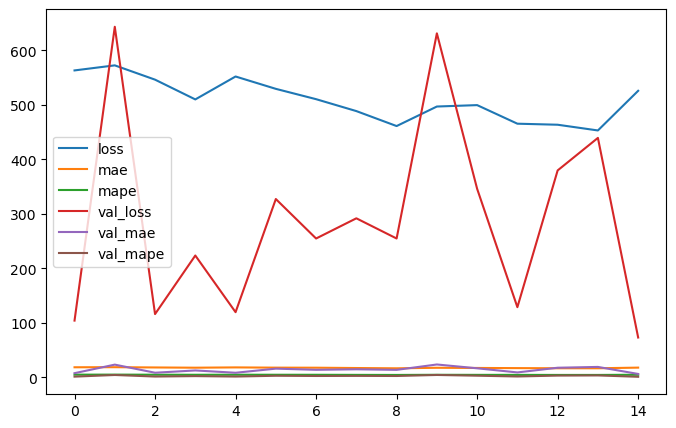

Epoch 1/15
43/43 [==============================] - 2s 54ms/step - loss: 713.9501 - mae: 20.2777 - mape: 4.9877 - val_loss: 614.2837 - val_mae: 23.4149 - val_mape: 5.4813
Epoch 2/15
43/43 [==============================] - 2s 52ms/step - loss: 707.8228 - mae: 20.1914 - mape: 5.0456 - val_loss: 437.2732 - val_mae: 19.2722 - val_mape: 4.5117
Epoch 3/15
43/43 [==============================] - 2s 48ms/step - loss: 612.5042 - mae: 18.7825 - mape: 4.7227 - val_loss: 441.2616 - val_mae: 19.4028 - val_mape: 4.5430
Epoch 4/15
43/43 [==============================] - 2s 48ms/step - loss: 673.7449 - mae: 19.5725 - mape: 4.8397 - val_loss: 414.6555 - val_mae: 18.5258 - val_mape: 4.3374
Epoch 5/15
43/43 [==============================] - 2s 52ms/step - loss: 689.8668 - mae: 19.9689 - mape: 4.9532 - val_loss: 353.8068 - val_mae: 16.8402 - val_mape: 3.9426
Epoch 6/15
43/43 [==============================] - 2s 48ms/step - loss: 630.5397 - mae: 18.9438 - mape: 4.7145 - val_loss: 160.2629 - val_mae: 1

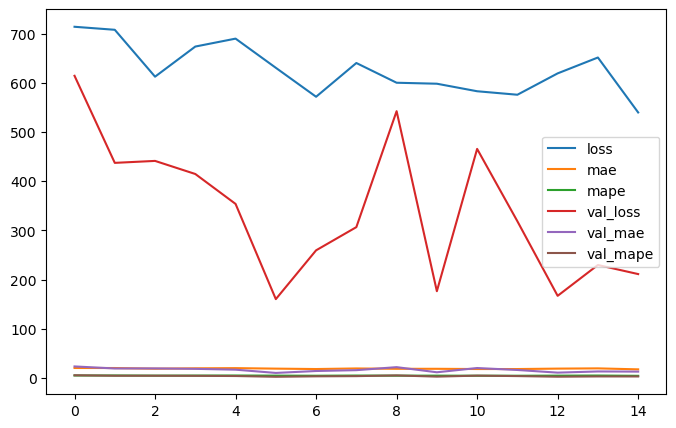

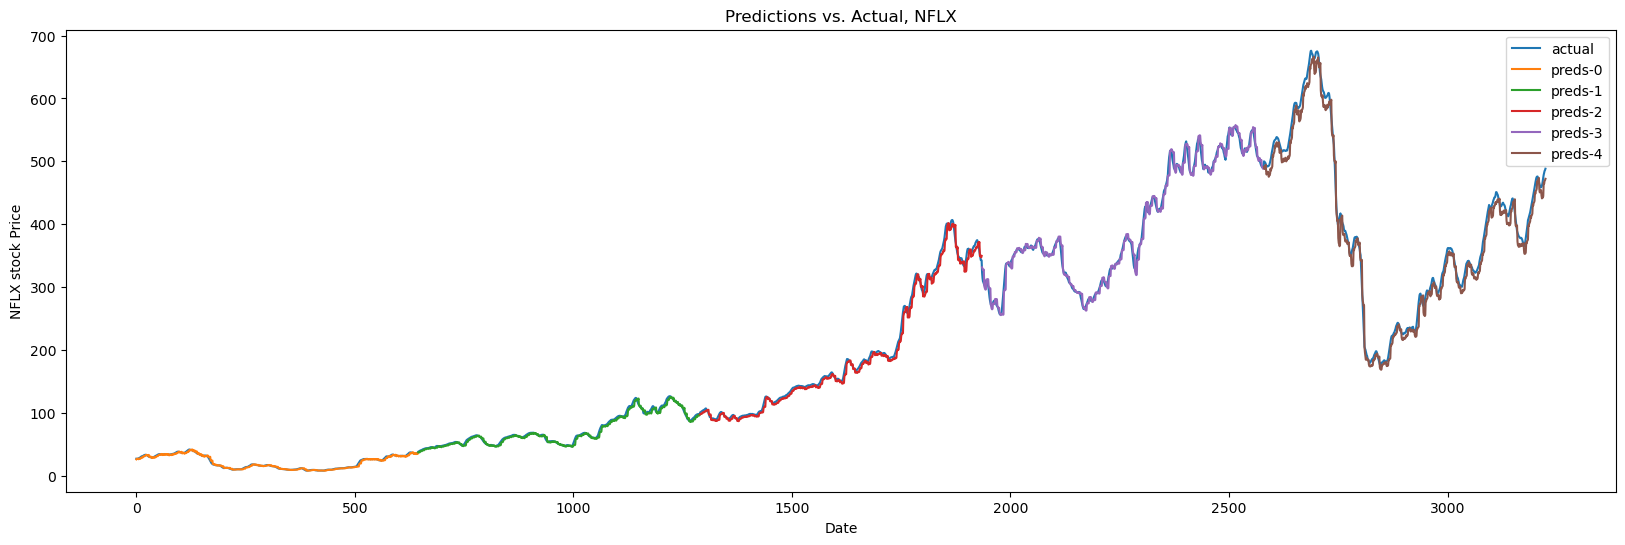

Epoch 1/50
35/35 [==============================] - 39s 143ms/step - loss: 9.0600 - mae: 2.8559 - mape: 82.8598 - val_loss: 4.3531 - val_mae: 1.8788 - val_mape: 59.1693
Epoch 2/50
35/35 [==============================] - 2s 63ms/step - loss: 2.9305 - mae: 1.2885 - mape: 37.1497 - val_loss: 0.4710 - val_mae: 0.5112 - val_mape: 16.1669
Epoch 3/50
35/35 [==============================] - 2s 67ms/step - loss: 0.3815 - mae: 0.4712 - mape: 13.6765 - val_loss: 0.0177 - val_mae: 0.1079 - val_mape: 3.5048
Epoch 4/50
35/35 [==============================] - 2s 69ms/step - loss: 0.2718 - mae: 0.4041 - mape: 11.6613 - val_loss: 0.0157 - val_mae: 0.1010 - val_mape: 3.3304
Epoch 5/50
35/35 [==============================] - 2s 70ms/step - loss: 0.2503 - mae: 0.3881 - mape: 11.2031 - val_loss: 0.0161 - val_mae: 0.1034 - val_mape: 3.4057
Epoch 6/50
35/35 [==============================] - 2s 62ms/step - loss: 0.2275 - mae: 0.3693 - mape: 10.6226 - val_loss: 0.0128 - val_mae: 0.0915 - val_mape: 3.0160


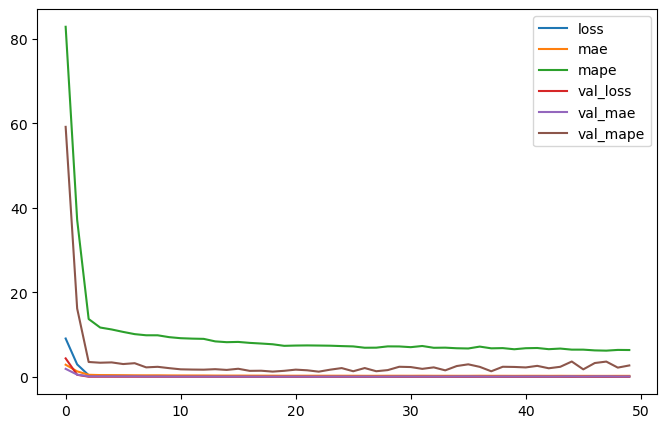

Epoch 1/15
43/43 [==============================] - 3s 60ms/step - loss: 0.1023 - mae: 0.2471 - mape: 5.7805 - val_loss: 0.0710 - val_mae: 0.1985 - val_mape: 2.8079
Epoch 2/15
43/43 [==============================] - 3s 61ms/step - loss: 0.1017 - mae: 0.2467 - mape: 5.7644 - val_loss: 0.0933 - val_mae: 0.2478 - val_mape: 3.5021
Epoch 3/15
43/43 [==============================] - 3s 71ms/step - loss: 0.0999 - mae: 0.2476 - mape: 5.8004 - val_loss: 0.0779 - val_mae: 0.2155 - val_mape: 3.0510
Epoch 4/15
43/43 [==============================] - 3s 71ms/step - loss: 0.1016 - mae: 0.2495 - mape: 5.8456 - val_loss: 0.0699 - val_mae: 0.1936 - val_mape: 2.7355
Epoch 5/15
43/43 [==============================] - 3s 60ms/step - loss: 0.0982 - mae: 0.2435 - mape: 5.6637 - val_loss: 0.1155 - val_mae: 0.2831 - val_mape: 3.9923
Epoch 6/15
43/43 [==============================] - 3s 61ms/step - loss: 0.0978 - mae: 0.2439 - mape: 5.7506 - val_loss: 0.0781 - val_mae: 0.2130 - val_mape: 3.0105
Epoch 7/15

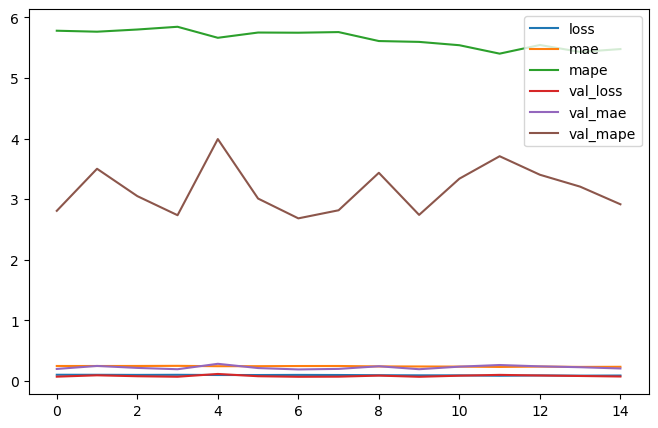

Epoch 1/15
43/43 [==============================] - 3s 72ms/step - loss: 5.7569 - mae: 1.6343 - mape: 6.1981 - val_loss: 3.0409 - val_mae: 1.3210 - val_mape: 2.0936
Epoch 2/15
43/43 [==============================] - 3s 75ms/step - loss: 5.3615 - mae: 1.5559 - mape: 6.0143 - val_loss: 3.0110 - val_mae: 1.2783 - val_mape: 2.0340
Epoch 3/15
43/43 [==============================] - 3s 68ms/step - loss: 4.9653 - mae: 1.5024 - mape: 5.8691 - val_loss: 3.2876 - val_mae: 1.4242 - val_mape: 2.2548
Epoch 4/15
43/43 [==============================] - 2s 55ms/step - loss: 5.2913 - mae: 1.5307 - mape: 5.7467 - val_loss: 2.6641 - val_mae: 1.1856 - val_mape: 1.8856
Epoch 5/15
43/43 [==============================] - 2s 54ms/step - loss: 4.7479 - mae: 1.4658 - mape: 5.7571 - val_loss: 4.1281 - val_mae: 1.6347 - val_mape: 2.5797
Epoch 6/15
43/43 [==============================] - 3s 62ms/step - loss: 4.7820 - mae: 1.4714 - mape: 5.6332 - val_loss: 3.6808 - val_mae: 1.5746 - val_mape: 2.4855
Epoch 7/15

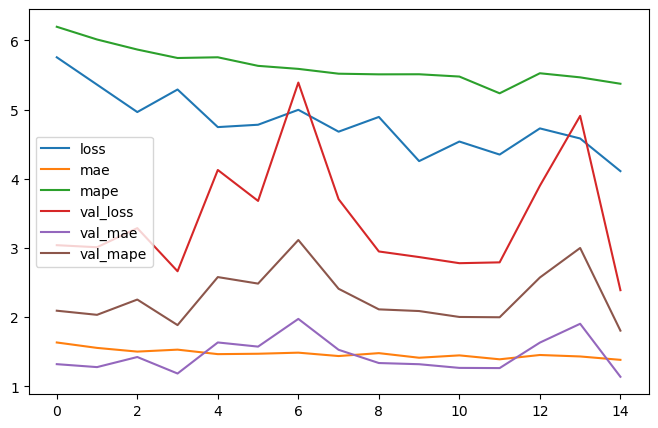

Epoch 1/15
43/43 [==============================] - 2s 50ms/step - loss: 25.3351 - mae: 3.7488 - mape: 5.9725 - val_loss: 22.8764 - val_mae: 3.8551 - val_mape: 2.8053
Epoch 2/15
43/43 [==============================] - 2s 45ms/step - loss: 23.4357 - mae: 3.5635 - mape: 5.6687 - val_loss: 31.9039 - val_mae: 4.7995 - val_mape: 3.5076
Epoch 3/15
43/43 [==============================] - 2s 51ms/step - loss: 20.0129 - mae: 3.3801 - mape: 5.5095 - val_loss: 16.8229 - val_mae: 3.0432 - val_mape: 2.1947
Epoch 4/15
43/43 [==============================] - 2s 47ms/step - loss: 20.5496 - mae: 3.3914 - mape: 5.4250 - val_loss: 18.4178 - val_mae: 3.3090 - val_mape: 2.3986
Epoch 5/15
43/43 [==============================] - 2s 47ms/step - loss: 21.9318 - mae: 3.4403 - mape: 5.4237 - val_loss: 16.5287 - val_mae: 2.8594 - val_mape: 2.0589
Epoch 6/15
43/43 [==============================] - 3s 65ms/step - loss: 21.9031 - mae: 3.4622 - mape: 5.5111 - val_loss: 17.4642 - val_mae: 3.0878 - val_mape: 2.228

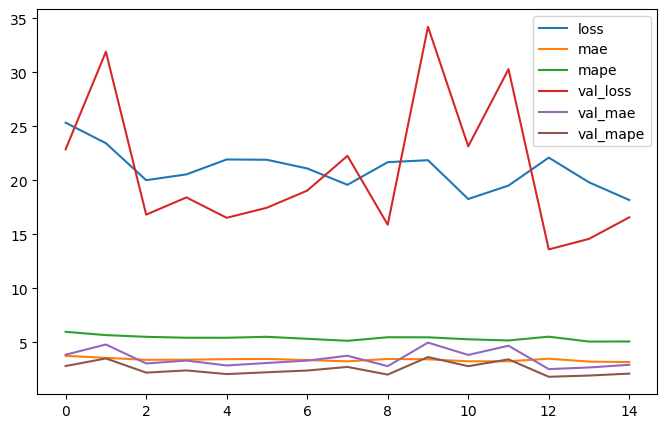

Epoch 1/15
43/43 [==============================] - 3s 65ms/step - loss: 230.0917 - mae: 11.4568 - mape: 5.7323 - val_loss: 153.2191 - val_mae: 9.7507 - val_mape: 2.1643
Epoch 2/15
43/43 [==============================] - 3s 62ms/step - loss: 214.2651 - mae: 11.0589 - mape: 5.4870 - val_loss: 134.3682 - val_mae: 9.1735 - val_mape: 2.0290
Epoch 3/15
43/43 [==============================] - 3s 59ms/step - loss: 183.1895 - mae: 10.2213 - mape: 5.1325 - val_loss: 140.4541 - val_mae: 9.3563 - val_mape: 2.0666
Epoch 4/15
43/43 [==============================] - 2s 58ms/step - loss: 192.7498 - mae: 10.5918 - mape: 5.2675 - val_loss: 135.3100 - val_mae: 9.1442 - val_mape: 2.0238
Epoch 5/15
43/43 [==============================] - 2s 57ms/step - loss: 186.7214 - mae: 10.1911 - mape: 5.0872 - val_loss: 139.4938 - val_mae: 9.2480 - val_mape: 2.0511
Epoch 6/15
43/43 [==============================] - 3s 60ms/step - loss: 205.7559 - mae: 10.7737 - mape: 5.3239 - val_loss: 149.8859 - val_mae: 10.156

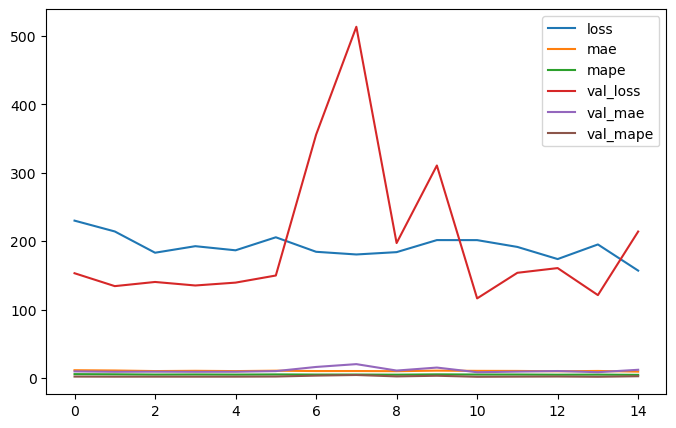

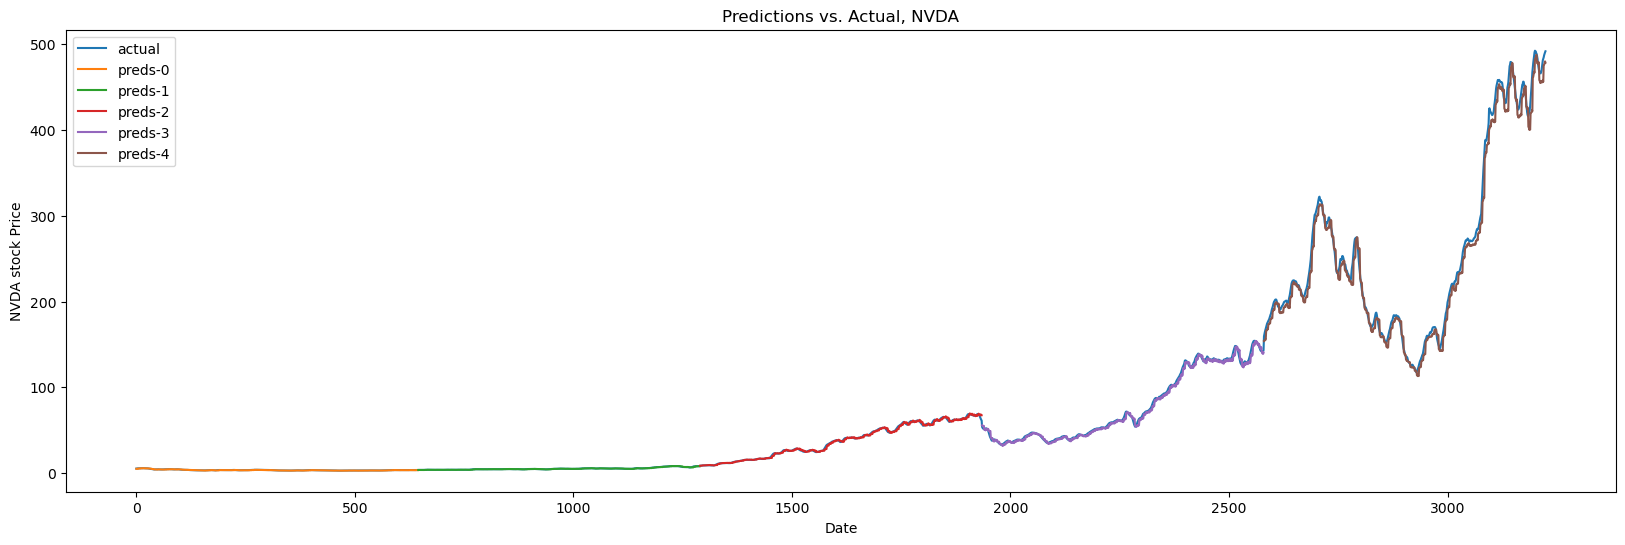

Epoch 1/50
35/35 [==============================] - 68s 141ms/step - loss: 2.4307 - mae: 1.4650 - mape: 74.9288 - val_loss: 12.7563 - val_mae: 2.9726 - val_mape: 55.4119
Epoch 2/50
35/35 [==============================] - 2s 65ms/step - loss: 0.9065 - mae: 0.6528 - mape: 33.6765 - val_loss: 9.1098 - val_mae: 2.2393 - val_mape: 39.9529
Epoch 3/50
35/35 [==============================] - 3s 72ms/step - loss: 0.8542 - mae: 0.5985 - mape: 30.7654 - val_loss: 9.0156 - val_mae: 2.2309 - val_mape: 40.0559
Epoch 4/50
35/35 [==============================] - 2s 69ms/step - loss: 0.8508 - mae: 0.5893 - mape: 30.3145 - val_loss: 8.7128 - val_mae: 2.1597 - val_mape: 38.8212
Epoch 5/50
35/35 [==============================] - 2s 68ms/step - loss: 0.8403 - mae: 0.5789 - mape: 29.7783 - val_loss: 8.4346 - val_mae: 2.0953 - val_mape: 37.8066
Epoch 6/50
35/35 [==============================] - 2s 69ms/step - loss: 0.8392 - mae: 0.5769 - mape: 29.6243 - val_loss: 8.1507 - val_mae: 2.0279 - val_mape: 36.

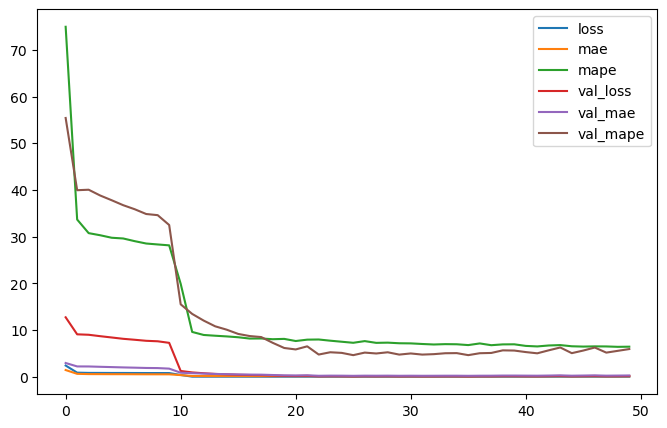

Epoch 1/15
43/43 [==============================] - 4s 89ms/step - loss: 1.1475 - mae: 0.8213 - mape: 6.8922 - val_loss: 0.4676 - val_mae: 0.5546 - val_mape: 4.1345
Epoch 2/15
43/43 [==============================] - 3s 71ms/step - loss: 1.2905 - mae: 0.8622 - mape: 7.1369 - val_loss: 0.5193 - val_mae: 0.5770 - val_mape: 4.2817
Epoch 3/15
43/43 [==============================] - 3s 78ms/step - loss: 1.1045 - mae: 0.8112 - mape: 6.8198 - val_loss: 0.4070 - val_mae: 0.5109 - val_mape: 3.7689
Epoch 4/15
43/43 [==============================] - 3s 81ms/step - loss: 1.1576 - mae: 0.8211 - mape: 6.8439 - val_loss: 0.4214 - val_mae: 0.5204 - val_mape: 3.8183
Epoch 5/15
43/43 [==============================] - 3s 76ms/step - loss: 0.9920 - mae: 0.7627 - mape: 6.2929 - val_loss: 0.3541 - val_mae: 0.4799 - val_mape: 3.5757
Epoch 6/15
43/43 [==============================] - 3s 70ms/step - loss: 1.0138 - mae: 0.7682 - mape: 6.3482 - val_loss: 0.3930 - val_mae: 0.4981 - val_mape: 3.6622
Epoch 7/15

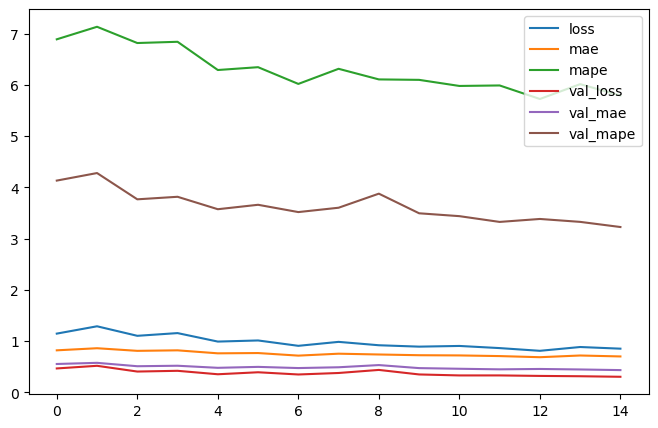

Epoch 1/15
43/43 [==============================] - 3s 82ms/step - loss: 1.6405 - mae: 0.9912 - mape: 5.6088 - val_loss: 1.0923 - val_mae: 0.7802 - val_mape: 3.7162
Epoch 2/15
43/43 [==============================] - 3s 66ms/step - loss: 1.5683 - mae: 0.9711 - mape: 5.4910 - val_loss: 1.3623 - val_mae: 0.9026 - val_mape: 4.3040
Epoch 3/15
43/43 [==============================] - 3s 67ms/step - loss: 1.4743 - mae: 0.9489 - mape: 5.3987 - val_loss: 0.7205 - val_mae: 0.6241 - val_mape: 2.9806
Epoch 4/15
43/43 [==============================] - 3s 67ms/step - loss: 1.5829 - mae: 0.9704 - mape: 5.4765 - val_loss: 0.9274 - val_mae: 0.7093 - val_mape: 3.3819
Epoch 5/15
43/43 [==============================] - 3s 75ms/step - loss: 1.3899 - mae: 0.9159 - mape: 5.1823 - val_loss: 0.7233 - val_mae: 0.6259 - val_mape: 2.9907
Epoch 6/15
43/43 [==============================] - 3s 65ms/step - loss: 1.4209 - mae: 0.9305 - mape: 5.2936 - val_loss: 0.7779 - val_mae: 0.6314 - val_mape: 3.0111
Epoch 7/15

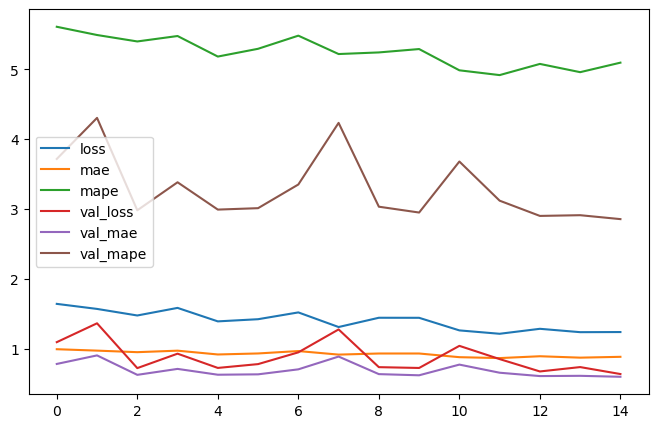

Epoch 1/15
43/43 [==============================] - 3s 70ms/step - loss: 17.9836 - mae: 2.5396 - mape: 6.4326 - val_loss: 225.4951 - val_mae: 13.1837 - val_mape: 5.7427
Epoch 2/15
43/43 [==============================] - 3s 65ms/step - loss: 21.9055 - mae: 2.6807 - mape: 6.5364 - val_loss: 102.1564 - val_mae: 7.7660 - val_mape: 3.4406
Epoch 3/15
43/43 [==============================] - 3s 63ms/step - loss: 22.1499 - mae: 2.6241 - mape: 6.2803 - val_loss: 94.8957 - val_mae: 7.6529 - val_mape: 3.3616
Epoch 4/15
43/43 [==============================] - 3s 70ms/step - loss: 17.5819 - mae: 2.3966 - mape: 5.8682 - val_loss: 97.1866 - val_mae: 7.3545 - val_mape: 3.2134
Epoch 5/15
43/43 [==============================] - 3s 63ms/step - loss: 19.8502 - mae: 2.5058 - mape: 6.1675 - val_loss: 123.3590 - val_mae: 8.0445 - val_mape: 3.4941
Epoch 6/15
43/43 [==============================] - 3s 66ms/step - loss: 16.7405 - mae: 2.3442 - mape: 5.6752 - val_loss: 85.0785 - val_mae: 6.9858 - val_mape: 3

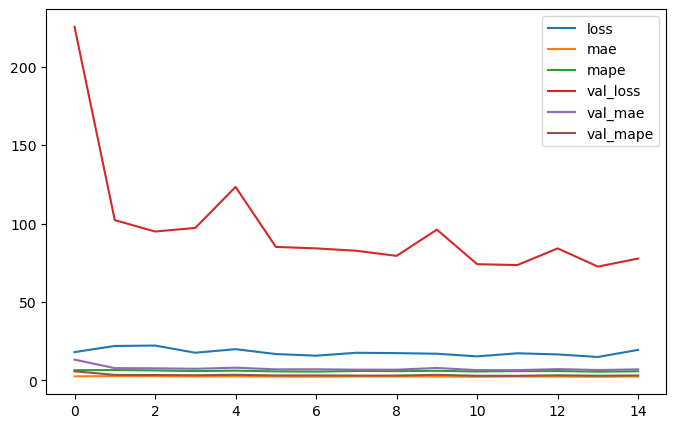

Epoch 1/15
43/43 [==============================] - 3s 69ms/step - loss: 311.2335 - mae: 13.6892 - mape: 5.5667 - val_loss: 50.8854 - val_mae: 5.7843 - val_mape: 2.3805
Epoch 2/15
43/43 [==============================] - 3s 72ms/step - loss: 293.6251 - mae: 13.0493 - mape: 5.3670 - val_loss: 225.5756 - val_mae: 14.0002 - val_mape: 5.6835
Epoch 3/15
43/43 [==============================] - 3s 69ms/step - loss: 343.5592 - mae: 14.3798 - mape: 5.8533 - val_loss: 43.4885 - val_mae: 4.9018 - val_mape: 2.0207
Epoch 4/15
43/43 [==============================] - 3s 66ms/step - loss: 293.4326 - mae: 13.2917 - mape: 5.4258 - val_loss: 83.4988 - val_mae: 7.7967 - val_mape: 3.1882
Epoch 5/15
43/43 [==============================] - 3s 67ms/step - loss: 304.3945 - mae: 13.4155 - mape: 5.4755 - val_loss: 43.0161 - val_mae: 4.9621 - val_mape: 2.0433
Epoch 6/15
43/43 [==============================] - 3s 67ms/step - loss: 279.5067 - mae: 12.8985 - mape: 5.2395 - val_loss: 175.4925 - val_mae: 12.1737 -

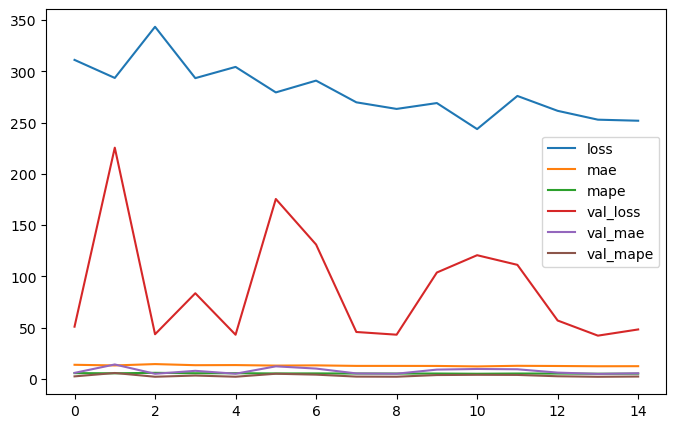

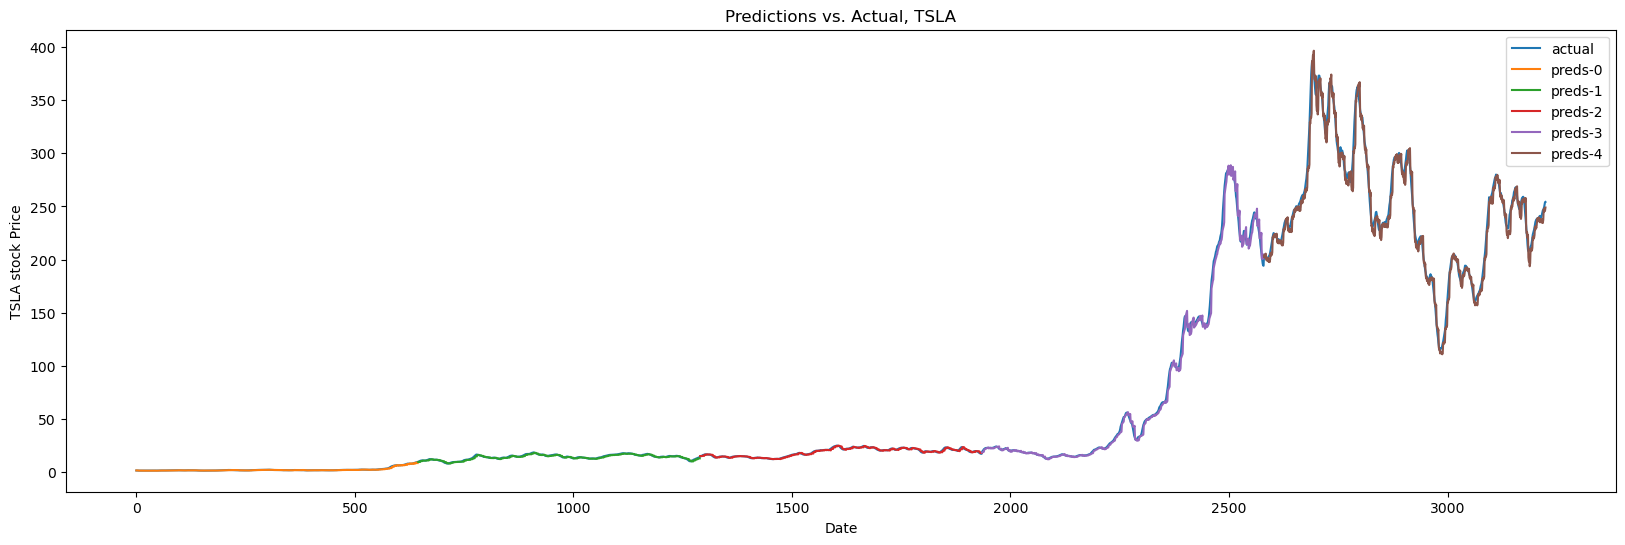

In [137]:
files = os.listdir("../../data/processed")

for file in files:
    transformer_prediction("../../data/processed/" + file)